In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns

import sklearn.metrics
from sklearn.cross_validation import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
import regression_models

In [3]:
redshift_file = np.load("data/redshift_mags.npz")
mags, redshifts = redshift_file['mags'][::10], redshift_file['z'][::10]

In [4]:
stacked = np.hstack((mags, redshifts.reshape(redshifts.shape[0], 1)))
col_names = ['u', 'g', 'r', 'i', 'z', 'redshift']
redshift_df = pd.DataFrame(stacked, columns=col_names)
print redshift_df

               u          g          r          i          z  redshift
0      17.150417  15.497092  14.674012  14.234288  13.907544  0.021222
1      20.723833  18.486593  17.462130  19.391457  16.403429  0.089312
2      18.538393  17.047279  16.253967  15.794540  15.453650  0.065183
3      20.351295  18.964243  17.937521  17.376566  17.034132  0.083268
4      19.610926  17.553694  16.564774  16.086264  15.708586  0.062151
5      19.986267  18.382534  17.670822  17.265265  16.939404  0.045652
6      21.041180  19.080349  17.874910  17.354071  16.923855  0.130222
7      20.610886  18.635859  17.539640  17.094013  16.762068  0.144802
8      18.586578  17.275490  16.636717  16.274286  16.097469  0.036452
9      21.241102  19.177706  18.019493  17.484449  17.058142  0.125411
10     20.891638  18.847141  17.699486  17.199553  16.776148  0.125820
11     17.891438  16.553202  15.909384  15.562485  15.327126  0.062498
12     20.200672  18.208666  17.101755  16.594025  16.227831  0.143917
13    

/Users/nobleWkennamer/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


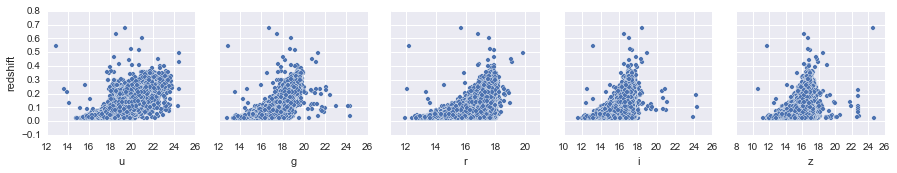

In [5]:
sns.pairplot(redshift_df, y_vars=col_names[-1], x_vars=col_names[:-1], palette='husl')

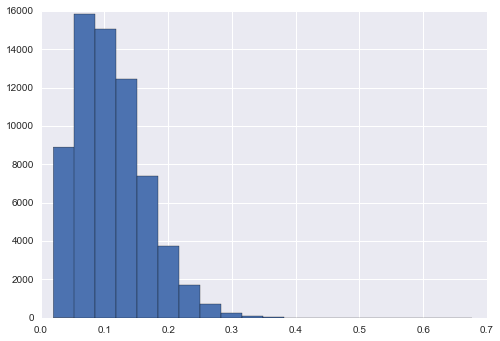

In [6]:
n, bins, patches = plt.hist(redshift_df['redshift'], bins=20)

In [7]:
colors_train, colors_test, redshift_train, redshift_test = train_test_split(mags, redshifts, 
                                                                            test_size=0.25, random_state=13)

##Compute Results

In [8]:
def compute_results(y_true, y_pred):
    
    explained_var = sklearn.metrics.explained_variance_score(y_true, y_pred)
    mean_abs_error = sklearn.metrics.mean_absolute_error(y_true, y_pred)
    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    mean_squared_error = sklearn.metrics.mean_squared_error(y_true, y_pred)
    
    results = {'scores': [explained_var, mean_abs_error, r2_score, mean_squared_error],
               'pred': y_pred}
    return results

##Models

In [9]:
def decision_tree_regression(x_train, y_train, x_test, y_test):
    d_tree = DecisionTreeRegressor(max_depth=8)
    d_tree.fit(x_train, y_train)
    predicted = d_tree.predict(x_test)
    return compute_results(y_test, predicted)

In [10]:
def random_forest_regression(x_train, y_train, x_test, y_test):
    rf = RandomForestRegressor(n_estimators=10,max_depth=8)
    rf.fit(x_train, y_train)
    predicted = rf.predict(x_test)
    return compute_results(y_test, predicted)

In [11]:
def linear_regression(x_train, y_train, x_test, y_test):
    #lr = LinearRegression(fit_intercept=True)
    #lr.fit(x_train, y_train)
    #predicted = lr.predict(x_test)
    predicted = regression_models.run_linear_regression(x_train, y_train, x_test, y_test, 10000, .001)
    return compute_results(y_test, predicted)

In [12]:
def knn_regression(x_train, y_train, x_test, y_test):
    knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
    knn.fit(x_train, y_train)
    predicted = knn.predict(x_test)
    return compute_results(y_test, predicted)

In [13]:
def ridge_regression(x_train, y_train, x_test, y_test):
    ridge = Ridge(alpha=0.1)
    ridge.fit(x_train, y_train)
    predicted = ridge.predict(x_test)
    return compute_results(y_test, predicted)

In [14]:
def boosted_dt_regression(x_train, y_train, x_test, y_test):
    grad = GradientBoostingRegressor(n_estimators=200, max_depth=5)
    grad.fit(x_train, y_train)
    predicted = grad.predict(x_test)
    return compute_results(y_test, predicted)

In [15]:
def plot_true_vs_pred(y_true, results, mags, band, band_name):
    colors_pl = matplotlib.cm.rainbow(np.linspace(0, 1, len(results)+1))
    plt.figure(figsize=(10, 10))
    plt.scatter(mags[:, band], y_true, label='True', color=colors_pl[0])
    i=1
    for model, results_dict in results.items():
        plt.scatter(mags[:, band], results_dict['pred'], label=model, color=colors_pl[i])
        i+=1
    
    plt.title(band_name + ' Magnitude vs. Redshift')
    plt.xlabel(band_name + ' Magnitue')
    plt.ylabel('Redshift')
    plt.legend(loc="upper left")

In [16]:
def run_models(x_train, y_train, x_test, y_test):
    results = dict()
    
    #RUN Models
    
    #Linear Regression
    lr_results = linear_regression(x_train, y_train, x_test, y_test)
    results['LR'] = lr_results
    
    #Decision Tree
    d_tree_results = decision_tree_regression(x_train, y_train, x_test, y_test)
    results['D Tree'] = d_tree_results
    
    #Random Forest
    rf_results = decision_tree_regression(x_train, y_train, x_test, y_test)
    results['RF'] = rf_results
    
    # KNN Regression
    knn_results = knn_regression(x_train, y_train, x_test, y_test)
    results['KNN'] = knn_results
    
    # Boosted Decision tree
    boosted_results = boosted_dt_regression(x_train, y_train, x_test, y_test)
    results['Bossted DT'] = boosted_results
    
    # Ridge Regression
    ridge_results = ridge_regression(x_train, y_train, x_test, y_test)
    results['Ridge Reg'] = ridge_results
    
    # Print reports
    scores = []
    models = []
    for model, results_dict in results.items():
        models.append(model)
        scores.append(results_dict['scores'])
    
    column_names = ['Explained Variance', 'Mean Absolute Error', 'R2 Score', 'Mean Squared Error']
    score_df = pd.DataFrame(scores, columns=column_names, index=models)
    print score_df
    
    # Plot Predicted
    plot_true_vs_pred(y_test, results, x_test, 0, 'u')
    plt.figure()
    plot_true_vs_pred(y_test, results, x_test, 1, 'g')
    plt.figure()
    plot_true_vs_pred(y_test, results, x_test, 2, 'r')
    plt.figure()
    plot_true_vs_pred(y_test, results, x_test, 3, 'i')
    plt.figure()
    plot_true_vs_pred(y_test, results, x_test, 4, 'z')
    
    

            Explained Variance  Mean Absolute Error  R2 Score  \
KNN                   0.800698             0.017680  0.800697   
Bossted DT            0.802571             0.017696  0.802537   
D Tree                0.701473             0.022383  0.701435   
RF                    0.702286             0.022376  0.702252   
Ridge Reg             0.615556             0.022984  0.615466   
LR                    0.365826             0.033775  0.365035   

            Mean Squared Error  
KNN                   0.000580  
Bossted DT            0.000575  
D Tree                0.000870  
RF                    0.000867  
Ridge Reg             0.001120  
LR                    0.001849  


/Users/nobleWkennamer/anaconda/lib/python2.7/site-packages/sklearn/ensemble/gradient_boosting.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


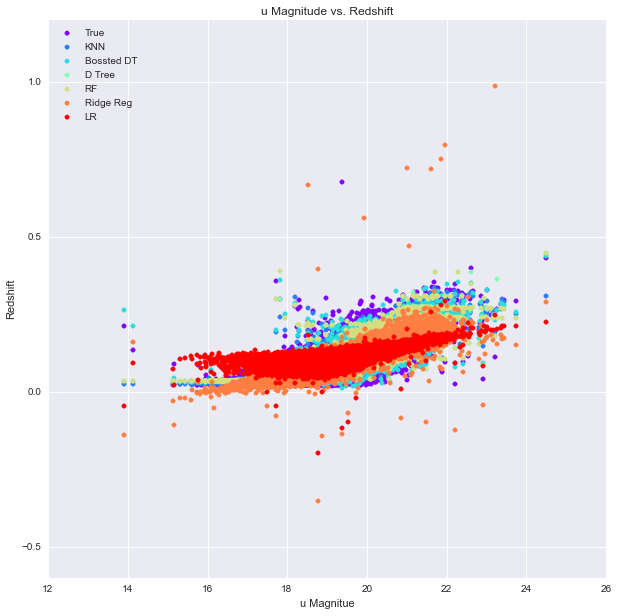

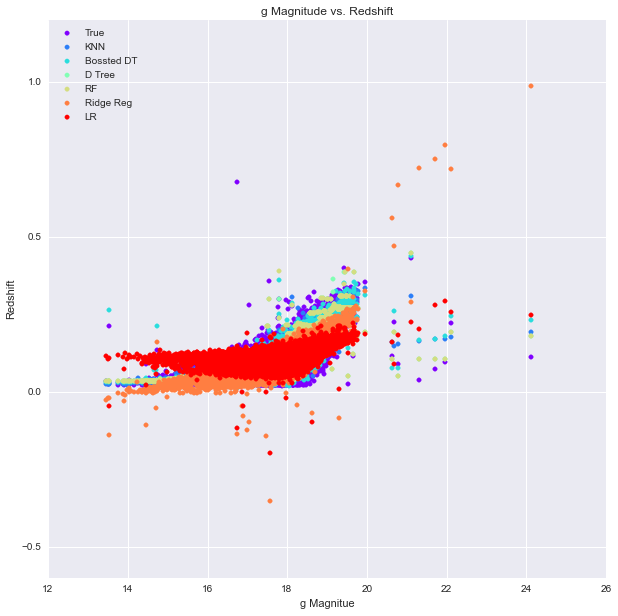

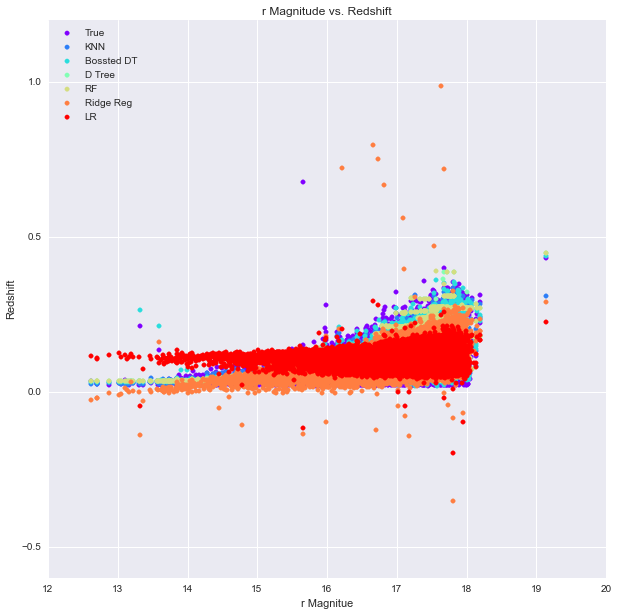

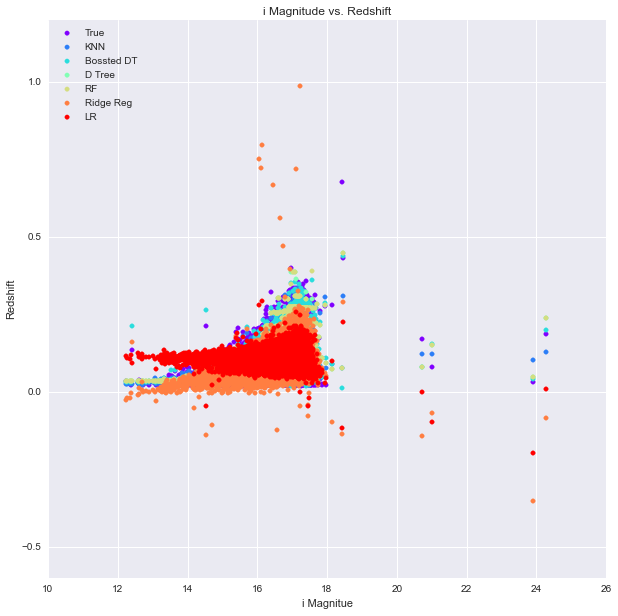

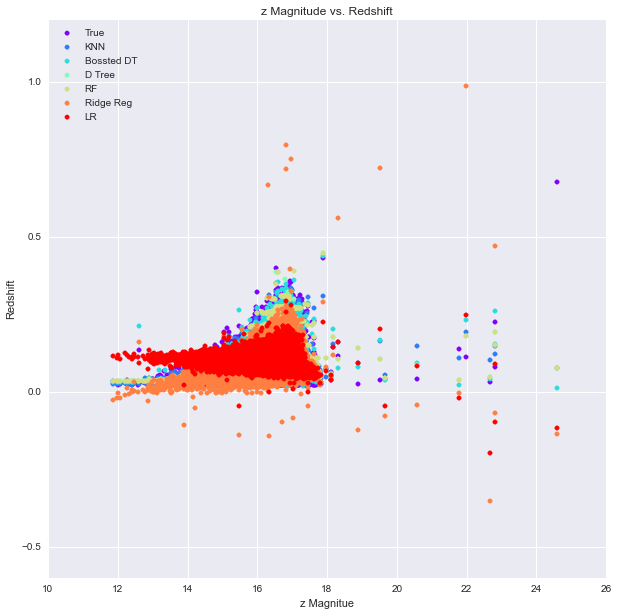

In [17]:
run_models(colors_train, redshift_train, colors_test, redshift_test)